In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_dirpath = "/content/drive/MyDrive/sadna/analysis_files"


Mounted at /content/drive


In [ ]:
combined_df = pd.read_excel(os.path.join(drive_dirpath, "combined_dataframes_fixed.xlsx"))

## Final Dataset Statistics

In [ ]:
# Count the number of times combined_df.dataset == 'tested'
tested_count = combined_df[combined_df.dataset == 'tested'].shape[0]
print(f"Number of rows where dataset is 'tested': {tested_count}")

untested_count = combined_df[combined_df.dataset == 'untested'].shape[0]
print(f"Number of rows where dataset is 'untested': {untested_count}\n")

# Count how many times each of A, B, C, D appears in combined_df.question_type
for question_type in ['A', 'B', 'C', 'D']:
  count = combined_df[combined_df.question_type == question_type].shape[0]
  print(f"Number of rows with question type {question_type}: {count}")

Number of rows where dataset is 'tested': 277
Number of rows where dataset is 'untested': 144

Number of rows with question type A: 220
Number of rows with question type B: 37
Number of rows with question type C: 212
Number of rows with question type D: 91


In [ ]:
# prompt: For each value in 'a','b','c',...,'p'  - count how many rows in combined_df.topics_covered contain the char, except if the cell value == 'na'

import string

alphabet = string.ascii_lowercase[:16]  # 'a' to 'p'

for char in alphabet:
  count = combined_df[
      combined_df.topics_covered.str.contains(char, na=False) &
      (combined_df.topics_covered != 'na')
  ].shape[0]
  print(f"Topic {char}  :   {count}")

Topic a  :   183
Topic b  :   38
Topic c  :   12
Topic d  :   58
Topic e  :   67
Topic f  :   90
Topic g  :   75
Topic h  :   69
Topic i  :   61
Topic j  :   19
Topic k  :   70
Topic l  :   13
Topic m  :   58
Topic n  :   26
Topic o  :   9
Topic p  :   66


In [ ]:
# remove questions without solutions (solution == FALSE)
# remove questions of type a and b
# remove questionsn that are not "tested"
# change question_type to upper case
# change multiple_choice_answer column to numbers
# keep columns: exam_year, semester, moed, question_number, multiple_choice_answer

combined_df['question_type'] = combined_df['question_type'].str.upper()
df_cd = combined_df[(combined_df['question_type'] == "C") | (combined_df['question_type'] == "D")]
df_cd = df_cd[(df_cd['dataset']=='tested')]
df_cd = df_cd[df_cd['has_solution'] == True].reset_index()
df_cd_small = df_cd[['exam_year','semester','moed','question_number','multiple_choice_answer','number_of_possible_answers','topics_covered','points']]
df_b = combined_df[(combined_df['question_type'] == "B")]
df_b = df_b[(df_b['dataset']=='tested')]
df_b = df_b[df_b['has_solution'] == True].reset_index()
df_b_small = df_b[['exam_year','semester','moed','question_number','answer_translation_latex','topics_covered','points']]

## Histogram of Number of Possible Answers and Boxlot of random guess probabilites

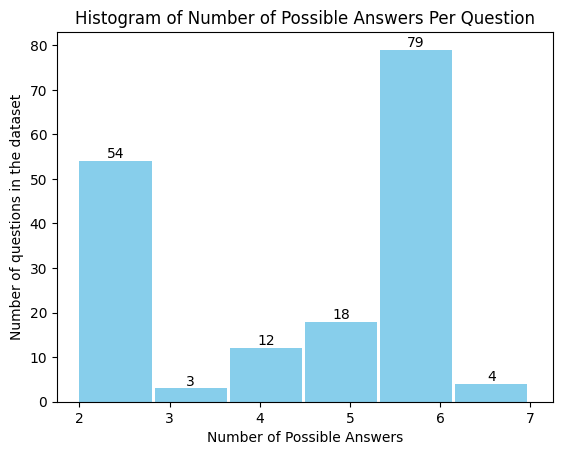

In [ ]:
counts, bins, patches = plt.hist(df_cd['number_of_possible_answers'], bins=6, color='skyblue', width=0.8)

# Add count labels above each bar
for count, patch in zip(counts, patches):
    plt.text(
        patch.get_x() + patch.get_width()/2,  # x position (center of bar)
        count,  # y position
        f'{int(count)}',  # label (convert to integer)
        ha='center',  # horizontal alignment
        va='bottom'   # vertical alignment
    )

plt.xlabel('Number of Possible Answers')
plt.ylabel('Number of questions in the dataset')
plt.title('Histogram of Number of Possible Answers Per Question')
plt.show()

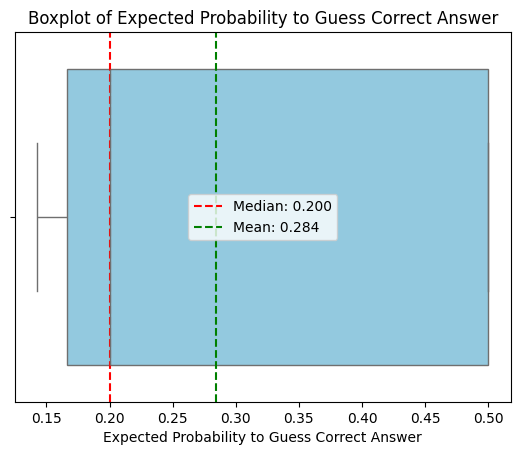

In [ ]:
df_cd['expected_prob_to_guess_correct_answer'] = 1 / df_cd['number_of_possible_answers']
plt.figure()
sns.boxplot(x=df_cd['expected_prob_to_guess_correct_answer'], color='skyblue')
plt.xlabel('Expected Probability to Guess Correct Answer')
plt.title('Boxplot of Expected Probability to Guess Correct Answer')

# Calculate and display the median
median_value = df_cd['expected_prob_to_guess_correct_answer'].median()
plt.axvline(median_value, color='red', linestyle='--', label=f'Median: {median_value:.3f}')

# Calculate and display the mean
mean_value = df_cd['expected_prob_to_guess_correct_answer'].mean()
plt.axvline(mean_value, color='green', linestyle='--', label=f'Mean: {mean_value:.3f}')

plt.legend()
plt.show()

In [ ]:
# Create a mapping for letters and True/False values
mapping = {
    1:1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7:7,
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G':7,
    'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g':7,
    'True': 1, 'False': 0, True: 1, False: 0
}

df_cd_small.loc[:, 'multiple_choice_answer'] = df_cd_small['multiple_choice_answer'].map(mapping)

In [ ]:
df_cd_small.loc[:,'semester'] = df_cd_small['semester'].str.upper()
df_cd_small.loc[:,'moed'] = df_cd_small['moed'].str.upper()

df_b_small.loc[:,'semester'] = df_cd_small['semester'].str.upper()
df_b_small.loc[:,'moed'] = df_cd_small['moed'].str.upper()

In [ ]:
model_df = pd.read_excel(os.path.join(drive_dirpath, "claude_answers_fixed.xlsx"))
model_df_b = pd.read_excel(os.path.join(drive_dirpath, "claude_answers_typeb_fixed.xlsx"))

In [ ]:
df_cd_expanded = df_cd_small.loc[df_cd_small.index.repeat(10)].reset_index(drop=True)
df_cd_expanded['fixed_model_reponses'] = model_df['fixed_chat_response']
df_cd_expanded['prompt_engineering_method'] = model_df['prompt_engineering_method']
df_cd_expanded['prompt_engineering_method'].fillna('-', inplace = True)

df_b_expanded = df_b_small.loc[df_b_small.index.repeat(10)].reset_index(drop=True)
df_b_expanded['model_reponses'] = model_df_b['chat_response']
df_b_expanded['prompt_engineering_method'] = model_df_b['prompt_engineering_method']
df_b_expanded['eval_by_hand'] = model_df_b['is_correct_eval_by_hand']
df_b_expanded['prompt_engineering_method'].fillna('-', inplace = True)

<ipython-input-12-8255ab014ebf>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cd_expanded['prompt_engineering_method'].fillna('-', inplace = True)
<ipython-input-12-8255ab014ebf>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [ ]:
df_cd_expanded

,exam_year,semester,moed,question_number,multiple_choice_answer,number_of_possible_answers,topics_covered,points,fixed_model_reponses,prompt_engineering_method
0,2002,A,A,2,2,5,p,6,2,-
1,2002,A,A,2,2,5,p,6,2,-
2,2002,A,A,2,2,5,p,6,2,-
3,2002,A,A,2,2,5,p,6,3,-
4,2002,A,A,2,2,5,p,6,3,-
...,...,...,...,...,...,...,...,...,...,...
1695,2018,A,A,14-e,0,2,"b,h",4,1,COT
1696,2018,A,A,14-e,0,2,"b,h",4,1,COT
1697,2018,A,A,14-e,0,2,"b,h",4,1,COT
1698,2018,A,A,14-e,0,2,"b,h",4,1,COT


In [ ]:
df_b_expanded_eval = df_b_expanded.dropna()
df_b_expanded_eval.rename(columns={'eval_by_hand':'tight_accuracy'}, inplace=True)
df_b_expanded_eval


<ipython-input-14-1179011fa813>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_expanded_eval.rename(columns={'eval_by_hand':'tight_accuracy'}, inplace=True)


,exam_year,semester,moed,question_number,answer_translation_latex,topics_covered,points,model_reponses,prompt_engineering_method,tight_accuracy
10,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,O(m),-,0.0
11,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,O(m log n),-,0.0
12,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,O(m),-,0.0
13,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,O(m log n),-,0.0
14,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,O(m),-,0.0
...,...,...,...,...,...,...,...,...,...,...
165,2017,B,"A,B",1-a,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",a,na,n\nn log n\nn log k\nn + k log k\nn²,COT,0.0
166,2017,B,"A,B",1-a,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",a,na,n\nn log n\nn log k\nn + k log k\nn²,COT,0.0
167,2017,B,"A,B",1-a,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",a,na,n\nn log k\nn + k log k\nn log n\nn²,COT,0.0
168,2017,B,"A,B",1-a,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",a,na,n\nn log n\nn log k\nn + k log k\nn²,COT,0.0


In [ ]:
df_cd_expanded['diff'] = df_cd_expanded['multiple_choice_answer'] - df_cd_expanded['fixed_model_reponses']
df_cd_expanded['tight_accuracy'] = (df_cd_expanded['diff'] == 0).astype(int)
df_cd_expanded = df_cd_expanded.drop(columns=['diff'])
df_cd_expanded

,exam_year,semester,moed,question_number,multiple_choice_answer,number_of_possible_answers,topics_covered,points,fixed_model_reponses,prompt_engineering_method,tight_accuracy
0,2002,A,A,2,2,5,p,6,2,-,1
1,2002,A,A,2,2,5,p,6,2,-,1
2,2002,A,A,2,2,5,p,6,2,-,1
3,2002,A,A,2,2,5,p,6,3,-,0
4,2002,A,A,2,2,5,p,6,3,-,0
...,...,...,...,...,...,...,...,...,...,...,...
1695,2018,A,A,14-e,0,2,"b,h",4,1,COT,0
1696,2018,A,A,14-e,0,2,"b,h",4,1,COT,0
1697,2018,A,A,14-e,0,2,"b,h",4,1,COT,0
1698,2018,A,A,14-e,0,2,"b,h",4,1,COT,0


In [ ]:
bcd_expanded_df = pd.concat([df_cd_expanded, df_b_expanded_eval])
bcd_expanded_df

,exam_year,semester,moed,question_number,multiple_choice_answer,number_of_possible_answers,topics_covered,points,fixed_model_reponses,prompt_engineering_method,tight_accuracy,answer_translation_latex,model_reponses
0,2002,A,A,2,2,5,p,6,2.0,-,1.0,NaN,NaN
1,2002,A,A,2,2,5,p,6,2.0,-,1.0,NaN,NaN
2,2002,A,A,2,2,5,p,6,2.0,-,1.0,NaN,NaN
3,2002,A,A,2,2,5,p,6,3.0,-,0.0,NaN,NaN
4,2002,A,A,2,2,5,p,6,3.0,-,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2017,B,"A,B",1-a,NaN,NaN,a,na,NaN,COT,0.0,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",n\nn log n\nn log k\nn + k log k\nn²
166,2017,B,"A,B",1-a,NaN,NaN,a,na,NaN,COT,0.0,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",n\nn log n\nn log k\nn + k log k\nn²
167,2017,B,"A,B",1-a,NaN,NaN,a,na,NaN,COT,0.0,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",n\nn log k\nn + k log k\nn log n\nn²
168,2017,B,"A,B",1-a,NaN,NaN,a,na,NaN,COT,0.0,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",n\nn log n\nn log k\nn + k log k\nn²


In [ ]:
bcd_expanded_grouped = bcd_expanded_df.groupby(['exam_year','semester','moed','question_number', 'prompt_engineering_method','topics_covered'])['tight_accuracy'].sum()
bcd_expanded_grouped_df = bcd_expanded_grouped.reset_index()
bcd_expanded_grouped_df['model_was_right_q'] = bcd_expanded_grouped_df['tight_accuracy'] > 2
bcd_expanded_grouped_df

,exam_year,semester,moed,question_number,prompt_engineering_method,topics_covered,tight_accuracy,model_was_right_q
0,2002,A,A,2,-,p,3.0,True
1,2002,A,A,2,COT,p,0.0,False
2,2002,A,A,3,-,g,5.0,True
3,2002,A,A,3,COT,g,5.0,True
4,2002,A,A,4,-,g,5.0,True
...,...,...,...,...,...,...,...,...
365,2018,A,B,6-a,COT,j,2.0,False
366,2018,A,B,8-a,-,g,4.0,True
367,2018,A,B,8-a,COT,g,3.0,True
368,2018,A,B,8-c,-,g,3.0,True


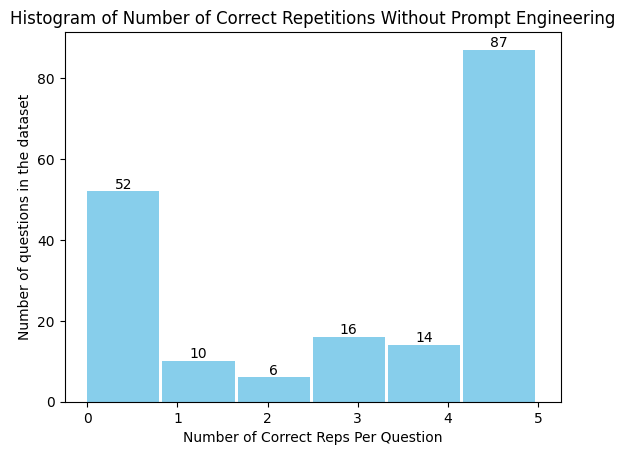

In [ ]:
plt.figure()
n, bins, patches = plt.hist(bcd_expanded_grouped_df[bcd_expanded_grouped_df['prompt_engineering_method'] == '-'].tight_accuracy, bins=6, color='skyblue', width=0.8)
plt.xlabel('Number of Correct Reps Per Question')
plt.ylabel('Number of questions in the dataset')
plt.title('Histogram of Number of Correct Repetitions Without Prompt Engineering')

# Annotate each bar with the count
for count, patch in zip(n, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
             ha='center', va='bottom')

plt.show()

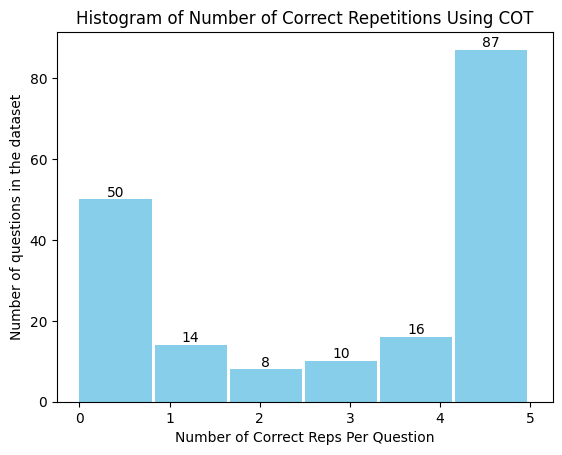

In [ ]:
plt.figure()
n, bins, patches = plt.hist(bcd_expanded_grouped_df[bcd_expanded_grouped_df['prompt_engineering_method'] == 'COT'].tight_accuracy, bins=6, color='skyblue', width=0.8)
plt.xlabel('Number of Correct Reps Per Question')
plt.ylabel('Number of questions in the dataset')
plt.title('Histogram of Number of Correct Repetitions Using COT')

# Annotate each bar with the count
for count, patch in zip(n, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
             ha='center', va='bottom')

plt.show()

In [ ]:
# counts of all topics (in each prompt!!!)
all_topic_counts = bcd_expanded_df['topics_covered'].str.split(',').explode().value_counts()
all_topic_counts

,count
topics_covered,
a,660
e,280
h,240
d,220
g,220
p,220
m,210
i,210
k,170


In [ ]:
cot_correct = bcd_expanded_df[(bcd_expanded_df['tight_accuracy'] == 1) & (bcd_expanded_df['prompt_engineering_method'] == 'COT')]
cot_correct_topic_cnt = cot_correct['topics_covered'].str.split(',').explode().value_counts()
cot_correct_topic_cnt

,count
topics_covered,
a,222
g,76
d,76
e,75
h,73
i,64
m,58
k,58
p,55


In [ ]:
no_cot_correct = bcd_expanded_df[(bcd_expanded_df['tight_accuracy'] == 1) & (bcd_expanded_df['prompt_engineering_method'] == '-')]
no_cot_correct_topic_cnt = no_cot_correct['topics_covered'].str.split(',').explode().value_counts()
no_cot_correct_topic_cnt

,count
topics_covered,
a,225
d,88
e,83
h,79
g,77
p,59
i,58
k,51
m,49


In [ ]:
all_by_topic = pd.merge(cot_correct_topic_cnt, no_cot_correct_topic_cnt, on='topics_covered')
all_by_topic.rename(columns={'count_x':'cot','count_y':'no_cot'}, inplace=True)
all_by_topic_2 = pd.merge(all_by_topic, all_topic_counts, on='topics_covered')
all_by_topic_2.rename(columns={'count':'total'}, inplace=True)
all_by_topic_2.loc['i'] += all_by_topic_2.loc['I']
all_by_topic_2.drop('I', inplace=True)
all_by_topic_2['cot/total'] = round(all_by_topic_2['cot']/all_by_topic_2['total'], 2)
all_by_topic_2['no_cot/total'] = round(all_by_topic_2['no_cot']/all_by_topic_2['total'], 2)
all_by_topic_2 = all_by_topic_2.reset_index().rename(columns={"index":"topics_covered"})
all_by_topic_2.sort_values(by=['topics_covered'], inplace=True)
all_by_topic_2

,topics_covered,cot,no_cot,total,cot/total,no_cot/total
0,a,222,225,660,0.34,0.34
10,b,24,24,140,0.17,0.17
14,c,5,4,30,0.17,0.13
2,d,76,88,220,0.35,0.40
3,e,75,83,280,0.27,0.30
9,f,41,44,150,0.27,0.29
1,g,76,77,220,0.35,0.35
4,h,73,79,240,0.30,0.33
5,i,69,63,220,0.31,0.29
11,j,18,20,70,0.26,0.29


## Comparison of Accuracy by Question Type

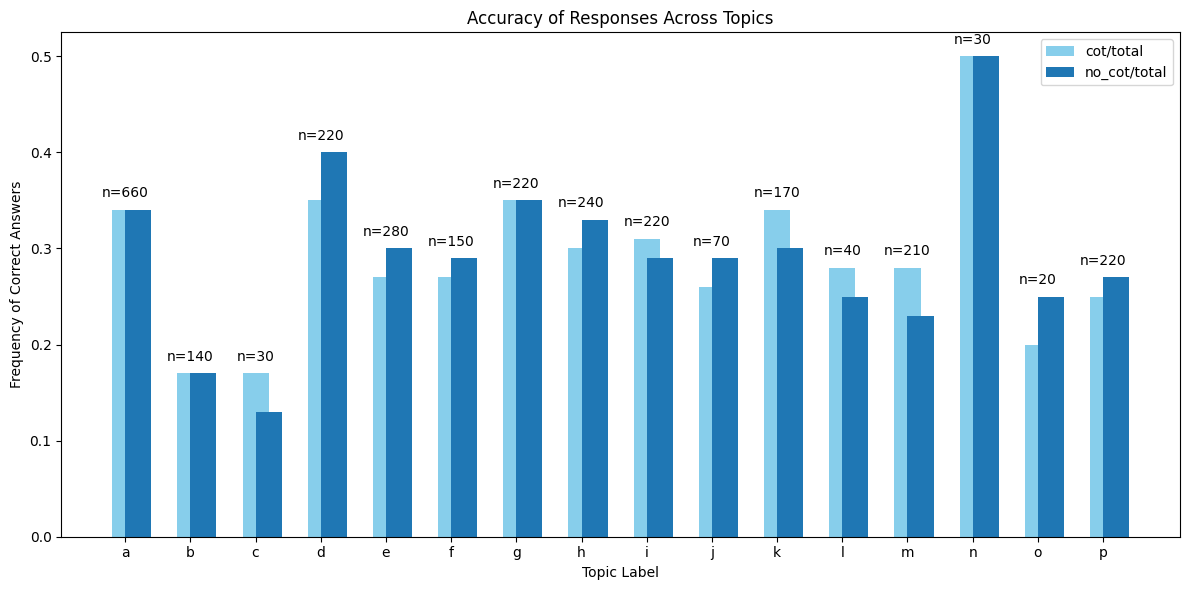

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
x = all_by_topic_2['topics_covered']


# Creating the bars for 'cot/total' and 'no_cot/total'
ax.bar(x, all_by_topic_2['cot/total'], width=0.4, label='cot/total', align='center', color='skyblue')
ax.bar(x, all_by_topic_2['no_cot/total'], width=0.4, label='no_cot/total', align='edge')

# Setting labels and title
ax.set_xlabel('Topic Label')
ax.set_ylabel('Frequency of Correct Answers')
ax.set_title('Accuracy of Responses Across Topics')
ax.legend()

# Adding total count labels
for i, topic in enumerate(x):
    total = all_by_topic_2.loc[all_by_topic_2['topics_covered'] == topic, 'total'].iloc[0]
    # Get the maximum height between the two bars for this topic
    cot_height = all_by_topic_2.loc[all_by_topic_2['topics_covered'] == topic, 'cot/total'].iloc[0]
    no_cot_height = all_by_topic_2.loc[all_by_topic_2['topics_covered'] == topic, 'no_cot/total'].iloc[0]
    max_height = max(cot_height, no_cot_height)

    # Place text slightly above the taller bar
    ax.text(i, max_height + 0.01, f'n={total}',
            ha='center', va='bottom')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
all_by_topic_2["avg_accuracy"] = (all_by_topic_2["cot/total"] + all_by_topic_2["no_cot/total"])/2

In [ ]:
all_by_topic_2.sort_values(by=['avg_accuracy'], inplace=True, ascending=False)
all_by_topic_2

,topics_covered,cot,no_cot,total,cot/total,no_cot/total,avg_accuracy
12,n,15,15,30,0.50,0.50,0.500
2,d,76,88,220,0.35,0.40,0.375
1,g,76,77,220,0.35,0.35,0.350
0,a,222,225,660,0.34,0.34,0.340
7,k,58,51,170,0.34,0.30,0.320
4,h,73,79,240,0.30,0.33,0.315
5,i,69,63,220,0.31,0.29,0.300
3,e,75,83,280,0.27,0.30,0.285
9,f,41,44,150,0.27,0.29,0.280
11,j,18,20,70,0.26,0.29,0.275
